In [1]:
# Useful starting lines
%matplotlib inline

import numpy as np
import scipy
import scipy.io
import scipy.sparse as sp
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## Load the Data
Note that `ratings` is a sparse matrix that in the shape of (num_items, num_users)

In [2]:
from helpers import load_data, preprocess_data

path_dataset = "data/data_train.csv"
ratings = load_data(path_dataset)

number of items: 1000, number of users: 10000


### Plot the number of ratings per movie and user

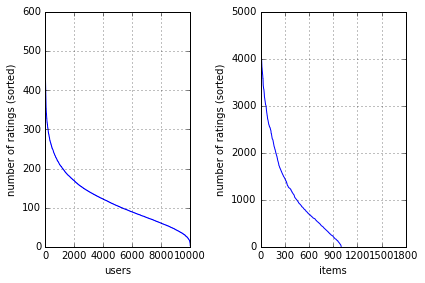

min # of items per user = 3, min # of users per item = 8.


In [3]:
from plots import plot_raw_data

num_items_per_user, num_users_per_item = plot_raw_data(ratings)

print("min # of items per user = {}, min # of users per item = {}.".format(
        min(num_items_per_user), min(num_users_per_item)))

### Split the data into a train and test set

In [4]:
def split_data(ratings, num_items_per_user, num_users_per_item,
               min_num_ratings, p_test=0.1):
    """split the ratings to training data and test data.
    Args:
        min_num_ratings: 
            all users and items we keep must have at least min_num_ratings per user and per item. 
    """
    # set seed
    np.random.seed(988)
    
    # select user and item based on the condition.
    valid_users = np.where(num_items_per_user >= min_num_ratings)[0]
    valid_items = np.where(num_users_per_item >= min_num_ratings)[0]
    valid_ratings = ratings[valid_items, :][: , valid_users]  
    
    # ***************************************************
    # INSERT YOUR CODE HERE
    # split the data and return train and test data. TODO
    # NOTE: we only consider users and movies that have more
    # than 10 ratings
    # ***************************************************
    
    # build rating matrix.
    rows, cols = ratings.get_shape()

    
    train = sp.lil_matrix((rows, cols))
    test = sp.lil_matrix((rows, cols))
    
    print(rows, cols)
    
    nz_row, nz_col = valid_ratings.nonzero()
    print(len(nz_col))
    print(len(nz_row))
    for i in range(0, len(nz_col)):
        rand = np.random.random()
        if rand > p_test:
            train[nz_row[i],nz_col[i]] = valid_ratings[nz_row[i],nz_col[i]]
        else:
            test[nz_row[i],nz_col[i]] = valid_ratings[nz_row[i],nz_col[i]]
               
    print("Total number of nonzero elements in original data:{v}".format(v=valid_ratings.nnz))
    print("Total number of nonzero elements in train data:{v}".format(v=train.nnz))
    print("Total number of nonzero elements in test data:{v}".format(v=test.nnz))
    return valid_ratings, train, test

In [5]:
from plots import plot_train_test_data

valid_ratings, train, test = split_data(
    ratings, num_items_per_user, num_users_per_item, min_num_ratings=10, p_test=0.1)

1000 10000
1176873
1176873
Total number of nonzero elements in original data:1176873
Total number of nonzero elements in train data:1058916
Total number of nonzero elements in test data:117957


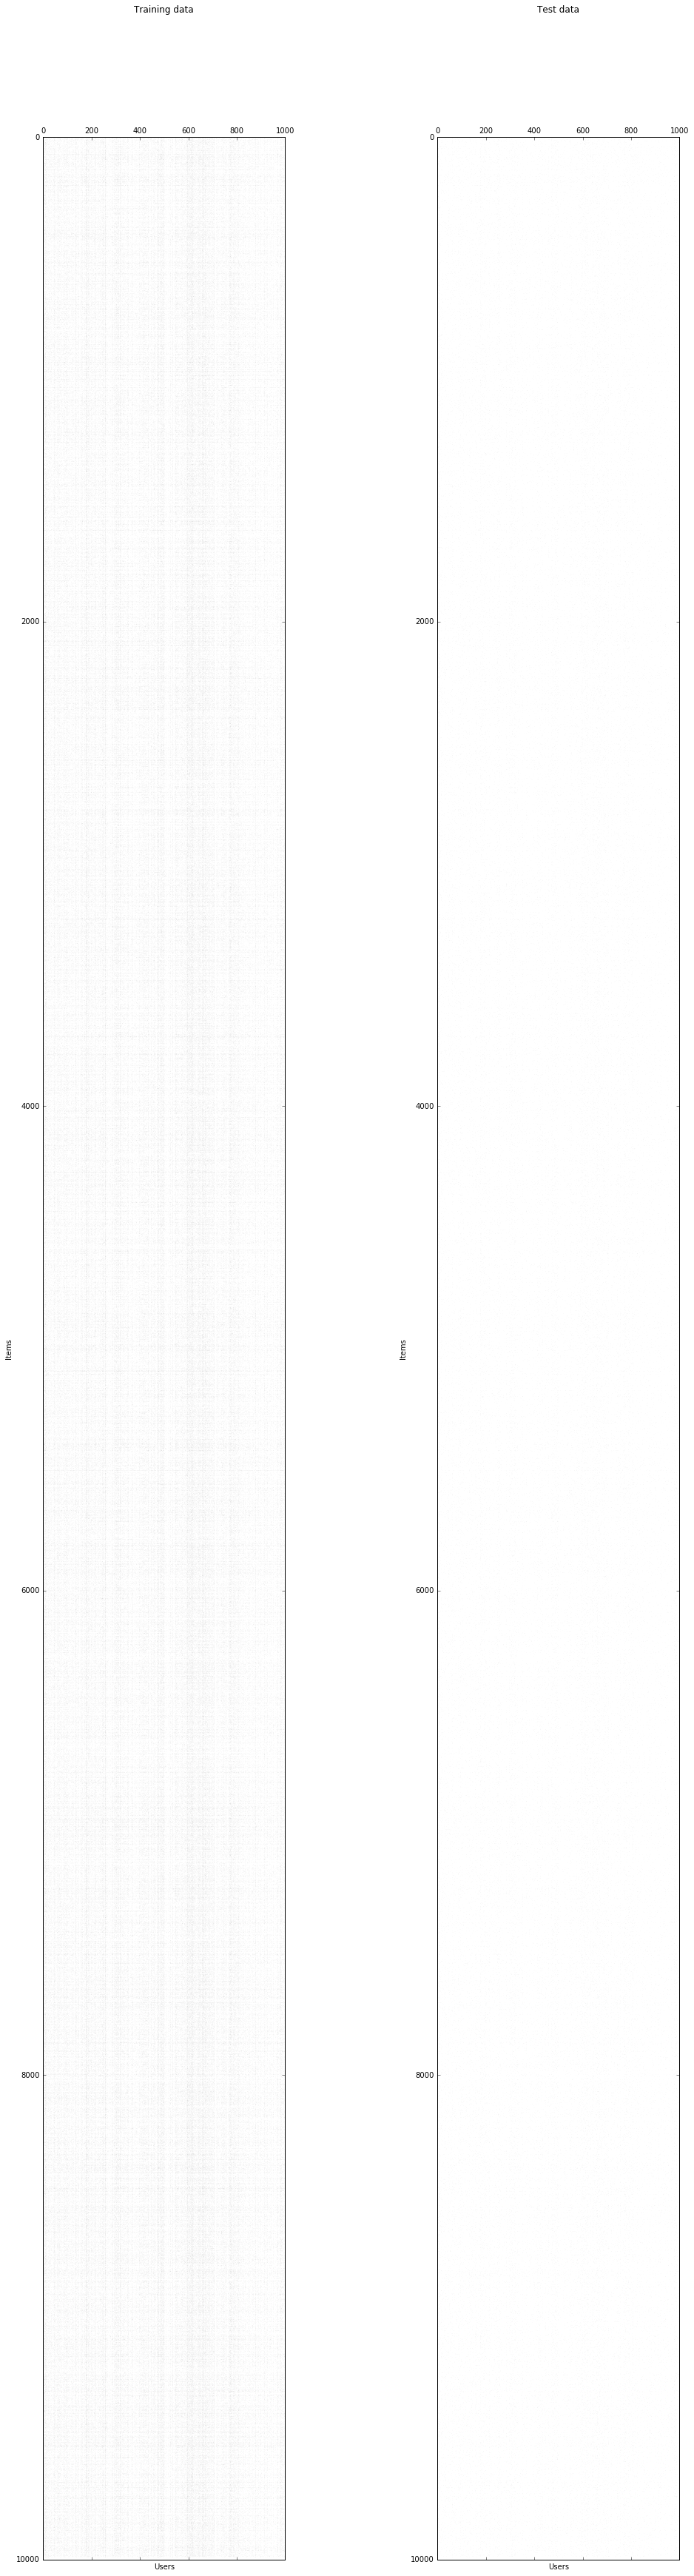

In [6]:
plot_train_test_data(train, test)

## Implementing Baselines 

### Use the global mean to do the prediction

In [7]:
from helpers import calculate_mse

def baseline_global_mean(train, test):
    """baseline method: use the global mean."""
    train_mean = train[train.nonzero()].mean()
    test_mean = test[test.nonzero()].mean()
    
    return train_mean, test_mean

baseline_global_mean(train, test)

(3.8570519285760154, 3.859465737514518)

### Use the user means as the prediction

In [8]:
def baseline_user_mean(train, test):
    """baseline method: use the user means as the prediction."""
    mse = 0
    num_items, num_users = train.shape
    
    train_means = train.sum(axis = 0) / (train.getnnz(axis=0)+1e-12)
    test_means = test.sum(axis = 0) / (test.getnnz(axis=0)+1e-12)
    
    return train_means, test_means

baseline_user_mean(train, test)[0].shape

(1, 10000)

### Use the item means as the prediction

In [9]:
def baseline_item_mean(train, test):
    """baseline method: use item means as the prediction."""
    mse = 0
    num_items, num_users = train.shape
    print(train.shape)
    
    train_means = train.sum(axis = 1) / (train.getnnz(axis=1)+1e-12).reshape(num_items, 1)
    test_means = test.sum(axis = 1) / (test.getnnz(axis=1)+1e-12).reshape(num_items, 1)
    
    return train_means, test_means
    
baseline_item_mean(train, test)

(1000, 10000)


(matrix([[ 3.34666667],
         [ 3.52742616],
         [ 3.4806867 ],
         [ 3.93247477],
         [ 3.556145  ],
         [ 4.6898928 ],
         [ 3.46009852],
         [ 3.89420573],
         [ 2.87234043],
         [ 3.64896755],
         [ 3.26711027],
         [ 3.17608696],
         [ 3.47381546],
         [ 4.41741071],
         [ 3.148382  ],
         [ 3.45013123],
         [ 2.66243386],
         [ 2.37898089],
         [ 3.50662252],
         [ 2.92479857],
         [ 3.56146572],
         [ 3.09403107],
         [ 3.34902597],
         [ 3.71812081],
         [ 3.52762923],
         [ 4.12345133],
         [ 3.7807571 ],
         [ 3.62577963],
         [ 3.54842767],
         [ 3.85470085],
         [ 3.19367589],
         [ 3.44378378],
         [ 3.39047619],
         [ 3.44919169],
         [ 3.08308605],
         [ 3.43965517],
         [ 3.72735346],
         [ 3.06037152],
         [ 3.07586207],
         [ 3.73142346],
         [ 2.88636364],
         [ 3.506

### Learn the Matrix Factorization using SGD

#### Initialize matrix factorization

In [10]:
def init_MF(train, num_features):
    """init the parameter for matrix factorization."""
    
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO
    # you should return:
    #     user_features: shape = num_features, num_user
    #     item_features: shape = num_features, num_item
    # ***************************************************
    num_items, num_users = train.shape
    user_features = np.ones((num_users, num_features))/num_features
    item_features = np.ones((num_items, num_features))/num_features
    
    return user_features, item_features

Compute the cost by the method of matrix factorization.


In [11]:
def compute_error(data, user_features, item_features, nz):
    """compute the loss (MSE) of the prediction of nonzero elements."""
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO
    # calculate rmse (we only consider nonzero entries.)
    # ***************************************************
    pred = item_features @ user_features.T
    diff = data[nz] - pred[nz]
    rmse = 1/2 * np.sum(np.square(diff)) / len(nz[0])
    
    return rmse

user_features, item_features = init_MF(train, 20)
compute_error(train, user_features, item_features, train.nonzero())
train.nonzero()

(array([  0,   0,   0, ..., 998, 998, 998], dtype=int32),
 array([  43,   60,   66, ..., 9979, 9981, 9986], dtype=int32))

In [12]:
from plots import visualization

def matrix_factorization_SGD(train, test):
    """matrix factorization by SGD."""
    # define parameters
    gamma = 0.001
    num_features = 20   # K in the lecture notes
    lambda_user = 0.1
    lambda_item = 0.7
    num_epochs = 50     # number of full passes through the train set
    errors = []
    errors_test = []
    
    # set seed
    np.random.seed(988)

    # init matrix
    user_features, item_features = init_MF(train, num_features)
    
    # find the non-zero ratings indices 
    nz_row, nz_col = train.nonzero()
    nz_train = list(zip(nz_row, nz_col))
    nz_row, nz_col = test.nonzero()
    nz_test = list(zip(nz_row, nz_col))
    

    rmse = compute_error(train, user_features, item_features, train.nonzero())

    print("iter: {}, RMSE on training set: {}.".format(-1, rmse))

    print("learn the matrix factorization using SGD...")
    
    for it in range(num_epochs):        
        # shuffle the training rating indices
        np.random.shuffle(nz_train)
        
        # decrease step size
        gamma /= 1.2
        
        mult = item_features @ user_features.T
        item_grad = np.zeros(item_features.shape)
        user_grad = np.zeros(user_features.shape)
        for d, n in nz_train:
        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO
        # do matrix factorization.
        # ***************************************************
            pred_error = train[d, n] - mult[d, n]
            item_grad[d,:] += pred_error * user_features[n,:] * gamma
            user_grad[n,:] += pred_error * item_features[d,:] * gamma
        
        item_features += item_grad
        user_features += user_grad
        
        rmse = compute_error(train, user_features, item_features, train.nonzero())
        #print("iter: {}, RMSE on training set: {}.".format(it, rmse))
        errors.append(rmse)
        
        print("iter: {}, RMSE on training set: {}.".format(it, rmse))
        
        rmse = compute_error(test, user_features, item_features, test.nonzero())
        #print("iter: {}, RMSE on test set: {}.".format(it, rmse))
        errors_test.append(rmse)
        
    # ***************************************************
    # TODO
    # evaluate the test error.
    # ***************************************************
    print(len(errors))
    print(len(errors_test))
    print(np.linspace(1,num_epochs,num_epochs))
    visualization(np.linspace(1,num_epochs,num_epochs),errors,errors_test)
    

#matrix_factorization_SGD(train, test)   

### Learn the Matrix Factorization using Alternating Least Squares

In [13]:
def nnz_items_along_axis(M, axis):
    indices = nz_indices_along_axis(M, axis)
    nnz_items = np.empty(indices.shape[0], 'int32')
    for i, e in enumerate(indices):
        nnz_items[i]= e.shape[0]
    return nnz_items

def nz_indices_along_axis(M, axis):
    """Takes a matrix M and axis=[0|1], and returns the indices of the non-zero elements along axis.
    If axis=0, returns for each row the indices of non-zero elements in that row. If axis=1, returns
    for each column the indices of non-zero elements in that column."""
    # return np.apply_along_axis(np.nonzero, axis, M) : wanted to use apply_along_axis, but couldn't get it to work
    # because of the "ValueError: setting an array element with a sequence"
    resultLength = M.shape[axis]
    indices = np.empty(resultLength, 'O')
    for k in range(resultLength):
        if axis == 0:
            a = np.nonzero(M[k, :])
        else:
            a = np.nonzero(M[:, k])
        indices[k] = a[0]
    return indices
    
U = np.array([[0, 1, 0, 0, 0], [0, 0, 0, 0, 0], [0, 1, 0, 1, 0], [1, 1, 1, 0, 0], [0, 1, 0, 0, 1]])
R = nz_indices_along_axis(U, 0)
print(R)
print(nnz_items_along_axis(U, 0))
#print(np.fromiter((i.shape for i in R), np.int32, -1))

def update_user_feature(
        train, W, lZ,
        nnz_items_per_user, nz_user_itemindices):
    """update and return user feature matrix."""
    # Q : why do we need the 'nnz_items_per_user' parameter (which I assume means :
    # "number of nonzero items per user") ?
    N = train.shape[1]
    K = W.shape[1]
    Z = np.zeros((N, K))
    for n in range(N):
        # nz_user_itemindices[n] is the set of row indices of X where user n rated an item ;
        # W_On are the rows of W corresponding to those indices
        W_On = W[nz_user_itemindices[n], :]
        X_On = (train[nz_user_itemindices[n], n]).toarray()
        Z[n,:] = np.linalg.inv(W_On.T.dot(W_On) + lZ * np.identity(K)).dot(W_On.T).dot(X_On).ravel()
    return Z

def update_item_feature(
        train, Z, lW,
        nnz_users_per_item, nz_item_userindices):
    """update and return item feature matrix."""
    D = train.shape[0]
    K = Z.shape[1]
    W = np.zeros((D, K))
    print("Z.shape :", Z.shape)
    for d in range(D):
        Z_Od = Z[nz_item_userindices[d], :]
        X_Od = train[d, nz_item_userindices[d]].toarray()
        W[d,:] = np.linalg.inv(Z_Od.T.dot(Z_Od) + lW * np.identity(K)).dot(Z_Od.T).dot(X_Od.T).ravel()
    return W

[array([1], dtype=int64) array([], dtype=int64) array([1, 3], dtype=int64)
 array([0, 1, 2], dtype=int64) array([1, 4], dtype=int64)]
[1 0 2 3 2]


In [14]:
from helpers import build_index_groups

def init_W(W):
    """Initialize the item matrix W by assigning the average
    rating for that movie as the first row, and
    small random numbers for the remaining entries."""
    W[0, :] = np.mean(W[0, :])
    for i in range(1, W.shape[0]):
        W[i, :] = np.random.rand()
    return W

def ALS(train, test):
    """Alternating Least Squares (ALS) algorithm."""
    # define parameters
    num_features = 20   # K in the lecture notes
    lambda_user = 0.1
    lambda_item = 0.7
    stop_criterion = 1e-4
    iteration = 1
    error_list = [0, 1]
    
    # set seed
    np.random.seed(988)

    # init ALS
    user_features, item_features = (np.zeros((train.shape[1], num_features)), np.zeros((train.shape[0], num_features)))

    # start ALS-WR algorithm
    # ***************************************************
    # nnz_items_per_user
    nz_user_itemindices = nz_indices_along_axis(train, 1)
    # nnz_users_per_item
    nz_item_userindices = nz_indices_along_axis(train, 0)
    
    nz_row, nz_col = train.nonzero()
    nz_train = list(zip(nz_row, nz_col))
    
    # initial W :
    item_features = init_W(item_features)
    while (np.fabs(error_list[1] - error_list[0]) > stop_criterion):
        user_features = update_user_feature(train, item_features, lambda_user, [], nz_user_itemindices)
        item_features = update_item_feature(train, user_features, lambda_item, [], nz_item_userindices)
        train_error = compute_error(train, item_features, user_features, nz_train, lambda_item, lambda_user)
        # update the error list :
        error_list[0] = error_list[1]
        error_list[1] = train_error
        iteration += 1
        print(iteration)
        if ((iteration % 100) == 0):
            print("ALS iteration", iteration, ": train error =", train_error)
    
    

ALS(train, test)

nz_user_itemindices[ 0 ] : [  9  60  67  83 205 309 391 438 471 473 545 590 594 595 604 641 642 778
 791 920 980]
W_On.shape : (21, 20)
X_On.shape : (21, 1)
Z[n,:].shape : (20,)


C:\Users\Melkior\Anaconda3\lib\site-packages\scipy\sparse\compressed.py:296: SparseEfficiencyWarning: Comparing sparse matrices using >= and <= is inefficient, using <, >, or !=, instead.
  "using <, >, or !=, instead.", SparseEfficiencyWarning)


[[ <21x1 sparse matrix of type '<class 'numpy.float64'>'
	with 21 stored elements in LInked List format>
  <21x1 sparse matrix of type '<class 'numpy.float64'>'
	with 21 stored elements in LInked List format>
  <21x1 sparse matrix of type '<class 'numpy.float64'>'
	with 21 stored elements in LInked List format>
  <21x1 sparse matrix of type '<class 'numpy.float64'>'
	with 21 stored elements in LInked List format>
  <21x1 sparse matrix of type '<class 'numpy.float64'>'
	with 21 stored elements in LInked List format>
  <21x1 sparse matrix of type '<class 'numpy.float64'>'
	with 21 stored elements in LInked List format>
  <21x1 sparse matrix of type '<class 'numpy.float64'>'
	with 21 stored elements in LInked List format>
  <21x1 sparse matrix of type '<class 'numpy.float64'>'
	with 21 stored elements in LInked List format>
  <21x1 sparse matrix of type '<class 'numpy.float64'>'
	with 21 stored elements in LInked List format>
  <21x1 sparse matrix of type '<class 'numpy.float64'>'
	with 2

ValueError: could not broadcast input array from shape (20,21) into shape (20)